In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import torch
import tqdm
import umap

import celltrip

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# Load Data and Policy

In [3]:
# Read data files
# adata, = celltrip.utility.processing.read_adatas('../data/VirtualCell/expression.h5ad', backed=True)
adata, = celltrip.utility.processing.read_adatas('s3://nkalafut-celltrip/VirtualCell/expression.h5ad', backed=True)
# Model location and name (should be prefix for .weights, .pre, and .mask file)
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251001', 800  # No mask
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251006', 800  # Normal
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007', 800  # 16 dim - Not much diff. betw. runs
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007-celllog', 800  # 16 dim - sample and log norm
prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251007-celllog-32', 800  # 32 dim
# prefix, training_step = 's3://nkalafut-celltrip/checkpoints/vcc-251008-celllog-64', 800  # 64 dim, 1024 PCA
# Generate or load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
with celltrip.utility.general.open_s3_or_local(f'{prefix}.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)
# assert (adata.obs['training'] == mask).all()
# Create sample env (kind of a dumb workaround, TODO)
m1, = preprocessing.transform([adata[:2].X])
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), compute_rewards=False, dim=32).eval().to('cuda')
# Load policy
policy = celltrip.policy.create_agent_from_env(
    env, forward_batch_size=100, vision_size=1_000).eval().to('cuda')  # TODO Forward batch size reduced
policy.load_checkpoint(f'{prefix}-{training_step:04}.weights');


In [4]:
preprocessing_nopca = celltrip.utility.processing.Preprocessing().load(f'{prefix}.pre')
preprocessing_nopca.pca_dim = None


# Generate Steady State

In [ ]:
# # Get random sample
# np.random.seed(42)
# sample_idx = np.sort(np.random.choice(adata.obs.shape[0], 10_000, replace=False))
# m1_raw = celltrip.utility.processing.chunk(adata[sample_idx].X, chunk_size=2_000)
# m1, = preprocessing.transform([m1_raw])


In [6]:
# # Create environment
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), compute_rewards=False, dim=8).eval(time_scale=1).to('cuda')

# # Simulate
# ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
# steady_state = ret[-1][-1, :, :env.dim]
# # target_state = env.modalities[env.target_modalities[0]].cpu()

# # Impute
# with torch.no_grad():
#     imputed_steady_state = policy.pinning[0](steady_state.to('cuda')).detach().cpu().numpy()
# imputed_steady_state, = preprocessing.inverse_transform([imputed_steady_state])

# # Compute accuracy
# mse = np.square(m1_raw - imputed_steady_state).mean()
# print(f'MSE: {mse:.3f}')


In [7]:
# # Latent space plot
# red = umap.UMAP(random_state=42)
# df = pd.DataFrame(index=sample_idx)
# df[['X_lat', 'Y_lat']] = red.fit_transform(steady_state)
# df['Target'] = adata[sample_idx].obs['target_gene'].to_numpy()
# df['Select Targets'] = df['Target']
# df.loc[~df['Target'].isin(['TMSB4X', 'EWSR1', 'non-targeting']), 'Select Targets'] = 'Other'
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# sns.scatterplot(df, x='X_lat', y='Y_lat', hue='Select Targets', s=5, legend=True, ax=ax)


# Predict Perturbation Outcomes

In [ ]:
# Get non-targeting
non_targeting_sample_idx = np.argwhere(adata.obs['target_gene']=='non-targeting').flatten()
np.random.seed(42)
non_targeting_sample_idx = np.sort(np.random.choice(non_targeting_sample_idx, 500, replace=False))  # Subsample for performance
non_targeting_raw = celltrip.utility.processing.chunk(adata[non_targeting_sample_idx].X, chunk_size=2_000)
non_targeting_trans, = preprocessing.transform([non_targeting_raw])

# Create environment
env = (
    celltrip.environment.EnvironmentBase(
        torch.tensor(non_targeting_trans), compute_rewards=False, dim=env.dim)
        .eval(time_scale=1)
        .set_incorporation_params(retention=1., binding=1.)  # Nothing at all
        .to('cuda'))

# Simulate (Runs at around .61x realtime on 38k cells!)
ret = celltrip.train.simulate_until_completion(env, policy, skip_states=100, store_states='cpu', progress_bar=True)
non_targeting_steady_state = ret[-1][-1]
print(f'Mean Velocity: {env.vel.abs().mean(dim=-1).mean():.3f}')

# Simulate with incorporation
# env.reset().set_state(non_targeting_steady_state.to('cuda'))
# ret = celltrip.train.simulate_until_completion(env, policy, incorporate_predictions=False, skip_states=100, store_states='cpu', progress_bar=True)
# env.solidify_offsets()
# non_targeting_steady_state = ret[-1][-1]
# print(env.vel.abs().mean(dim=-1).mean())

# Impute
with torch.no_grad():
    imputed_non_targeting_steady_state = policy.pinning[0](non_targeting_steady_state[..., :env.dim].to('cuda')).detach().cpu().numpy()
imputed_non_targeting_steady_state, = preprocessing.inverse_transform([imputed_non_targeting_steady_state])



0it [00:00, ?it/s]


1it [00:03,  3.76s/it]


5it [00:03,  1.71it/s]


13it [00:03,  5.58it/s]


22it [00:04, 11.06it/s]


31it [00:04, 17.62it/s]


40it [00:04, 25.08it/s]


48it [00:04, 32.22it/s]


56it [00:04, 39.56it/s]


64it [00:04, 46.49it/s]


72it [00:04, 52.80it/s]


80it [00:04, 58.24it/s]


88it [00:04, 62.66it/s]


96it [00:05, 66.60it/s]


104it [00:05, 66.55it/s]


112it [00:05, 42.38it/s]


118it [00:05, 36.42it/s]


126it [00:05, 43.35it/s]


134it [00:05, 49.52it/s]


142it [00:06, 56.09it/s]


150it [00:06, 61.12it/s]


158it [00:06, 65.50it/s]


166it [00:06, 68.56it/s]


174it [00:06, 70.76it/s]


182it [00:06, 73.24it/s]


190it [00:06, 74.85it/s]


198it [00:06, 75.55it/s]


206it [00:06, 76.19it/s]


214it [00:06, 76.41it/s]


222it [00:07, 59.38it/s]


229it [00:07, 42.29it/s]


235it [00:07, 39.95it/s]


243it [00:07, 47.27it/s]


251it [00:07, 53.76it/s]


259it [00:07, 59.86it/s]


267it [00:08, 64.74it/s]


275it [00:08, 68.19it/s]


284it [00:08, 72.08it/s]


293it [00:08, 74.58it/s]


301it [00:08, 75.77it/s]


309it [00:08, 76.16it/s]


318it [00:08, 77.84it/s]


327it [00:08, 77.14it/s]


335it [00:09, 50.45it/s]


342it [00:09, 47.05it/s]


348it [00:09, 44.27it/s]


357it [00:09, 52.24it/s]


365it [00:09, 58.36it/s]


373it [00:09, 63.34it/s]


381it [00:09, 67.53it/s]


389it [00:09, 70.52it/s]


397it [00:10, 72.19it/s]


405it [00:10, 74.03it/s]


413it [00:10, 75.62it/s]


421it [00:10, 76.77it/s]


429it [00:10, 76.53it/s]


437it [00:10, 76.69it/s]


445it [00:10, 67.57it/s]


452it [00:10, 57.00it/s]


459it [00:11, 48.06it/s]


465it [00:11, 46.88it/s]


471it [00:11, 48.33it/s]


477it [00:11, 49.53it/s]


485it [00:11, 56.52it/s]


493it [00:11, 61.67it/s]


501it [00:11, 65.56it/s]


509it [00:11, 68.62it/s]


517it [00:12, 71.57it/s]


525it [00:12, 73.69it/s]


533it [00:12, 74.79it/s]


541it [00:12, 75.56it/s]


549it [00:12, 76.75it/s]


557it [00:12, 76.96it/s]


565it [00:12, 77.59it/s]


573it [00:12, 63.06it/s]


580it [00:13, 47.58it/s]


586it [00:13, 43.01it/s]


594it [00:13, 49.78it/s]


602it [00:13, 56.37it/s]


610it [00:13, 61.51it/s]


618it [00:13, 65.58it/s]


626it [00:13, 68.57it/s]


634it [00:13, 71.55it/s]


642it [00:13, 73.17it/s]


650it [00:14, 74.04it/s]


658it [00:14, 75.00it/s]


666it [00:14, 74.42it/s]


675it [00:14, 76.37it/s]


683it [00:14, 69.36it/s]


691it [00:14, 61.68it/s]


698it [00:14, 57.04it/s]


704it [00:14, 55.56it/s]


710it [00:15, 52.94it/s]


718it [00:15, 57.75it/s]


726it [00:15, 61.75it/s]


734it [00:15, 65.56it/s]


742it [00:15, 67.83it/s]


750it [00:15, 69.89it/s]


758it [00:15, 72.56it/s]


766it [00:15, 74.04it/s]


775it [00:15, 75.51it/s]


783it [00:16, 76.04it/s]


791it [00:16, 75.71it/s]


799it [00:16, 76.25it/s]


807it [00:16, 70.69it/s]


815it [00:16, 49.13it/s]


821it [00:16, 47.19it/s]


827it [00:17, 41.63it/s]


834it [00:17, 47.25it/s]


842it [00:17, 54.29it/s]


850it [00:17, 60.12it/s]


858it [00:17, 64.69it/s]


866it [00:17, 67.76it/s]


874it [00:17, 70.02it/s]


882it [00:17, 71.77it/s]


890it [00:17, 72.98it/s]


898it [00:17, 73.82it/s]


906it [00:18, 74.36it/s]


914it [00:18, 75.00it/s]


922it [00:18, 64.66it/s]


929it [00:18, 43.95it/s]


935it [00:18, 44.18it/s]


941it [00:18, 46.21it/s]


949it [00:18, 52.99it/s]


957it [00:19, 59.23it/s]


965it [00:19, 64.24it/s]


973it [00:19, 68.00it/s]


981it [00:19, 71.17it/s]


989it [00:19, 73.58it/s]


997it [00:19, 75.36it/s]


1005it [00:19, 76.43it/s]


1013it [00:19, 77.27it/s]


1022it [00:19, 78.73it/s]


1031it [00:19, 80.19it/s]


1040it [00:20, 75.17it/s]


1048it [00:20, 66.14it/s]


1055it [00:20, 61.08it/s]


1062it [00:20, 54.53it/s]


1068it [00:20, 55.09it/s]


1077it [00:20, 61.99it/s]


1086it [00:20, 67.36it/s]


1094it [00:21, 70.67it/s]


1102it [00:21, 73.16it/s]


1110it [00:21, 74.93it/s]


1119it [00:21, 77.41it/s]


1128it [00:21, 78.55it/s]


1136it [00:21, 78.89it/s]


1145it [00:21, 79.09it/s]


1154it [00:21, 79.50it/s]


1162it [00:21, 78.68it/s]


1170it [00:22, 71.75it/s]


1178it [00:22, 64.10it/s]


1185it [00:22, 59.70it/s]


1192it [00:22, 50.79it/s]


1198it [00:22, 49.21it/s]


1206it [00:22, 55.22it/s]


1214it [00:22, 61.13it/s]


1222it [00:22, 65.84it/s]


1230it [00:23, 69.46it/s]


1238it [00:23, 70.91it/s]


1246it [00:23, 73.25it/s]


1254it [00:23, 73.52it/s]


1262it [00:23, 75.21it/s]


1270it [00:23, 75.55it/s]


1278it [00:23, 76.21it/s]


1281it [00:23, 54.02it/s]

Mean Velocity: 0.006


In [ ]:
imputed_means, raw_means = [], []
num_genes = 20
gene_list = ['_ctl_pre', '_ctl_post'] + adata.obs.loc[adata.obs['target_gene']!='non-targeting'].groupby('target_gene', observed=True).size().sort_values(ascending=False).index.to_numpy()[:num_genes].tolist()
for gene in (pbar := tqdm.tqdm(gene_list)):
    # Update pbar
    pbar.set_description(gene)

    # Find gene
    if gene == '_ctl_pre':
        # imputed_means.append(preprocessing_nopca.transform([imputed_non_targeting_steady_state])[0].mean(axis=0))
        # raw_means.append(preprocessing_nopca.transform([non_targeting_raw])[0].mean(axis=0))
        imputed_means.append(imputed_non_targeting_steady_state.mean(axis=0))
        raw_means.append(non_targeting_raw.mean(axis=0))
        continue
    elif gene == '_ctl_post':
        gene_idx = []
    else:
        gene_idx = np.argwhere(adata.var.index == gene).flatten()
        assert len(gene_idx) == 1

    # # Get perturbation (~65s)
    # iso_modality = celltrip.utility.processing.chunk(
    #     non_targeting_raw, chunk_size=2_000, func=lambda x: preprocessing.transform(x, subset_modality=0, subset_features=gene_idx)[0])
    # iso_modality = torch.tensor(iso_modality).to('cuda')
    # env.offset = -iso_modality

    # Reset environment and simulate
    env.reset().set_state(non_targeting_steady_state.to('cuda'))
    ret = celltrip.train.simulate_until_completion(
        env, policy,
        incorporate_predictions=False,
        env_hooks=[
            # celltrip.utility.hooks.clamp_input_features_hook(
            #     gene_idx, preprocessing, feature_targets=0., modality_idx=0, device=env.device),
            celltrip.utility.hooks.clamp_inverted_features_hook(
                gene_idx, preprocessing, feature_targets=0., modality_idx=0),
        ],
        action_hooks=[
            celltrip.utility.hooks.move_toward_targets_hook(
                gene_idx, feature_targets=0., pinning=policy.pinning[0],
                preprocessing=preprocessing, modality_idx=0,
                factor=1, device=env.device),
        ],  # Factor 1e4
        skip_states=100, store_states='cpu', progress_bar=False)
    gene_steady_state = ret[-1][-1]
    print(f'Mean Velocity: {env.vel.abs().mean(dim=-1).mean():.3f}')

    # Impute
    with torch.no_grad():
        imputed_gene_steady_state = policy.pinning[0](gene_steady_state[..., :env.dim].to('cuda')).detach().cpu().numpy()
    imputed_gene_steady_state, = preprocessing.inverse_transform([imputed_gene_steady_state])

    # Get true perturbed data
    if gene == '_ctl_post':
        gene_raw = non_targeting_raw
    else:
        gene_sample_idx = np.argwhere(adata.obs['target_gene']==gene).flatten()
        gene_raw = celltrip.utility.processing.chunk(adata[gene_sample_idx].X, chunk_size=2_000)
    
    # Record
    # imputed_means.append(preprocessing_nopca.transform([imputed_gene_steady_state])[0].mean(axis=0))
    # raw_means.append(preprocessing_nopca.transform([gene_raw])[0].mean(axis=0))
    imputed_means.append(imputed_gene_steady_state.mean(axis=0))
    raw_means.append(gene_raw.mean(axis=0))

# Aggregate
imputed_means = np.stack(imputed_means, axis=0)
imputed_means = pd.DataFrame(imputed_means, index=gene_list, columns=adata.var.index.to_numpy())
raw_means = np.stack(raw_means, axis=0)  # np.concatenate(raw_means, axis=0)
raw_means = pd.DataFrame(raw_means, index=gene_list, columns=adata.var.index.to_numpy())

# Save
imputed_means.to_csv('../plots/vcc/imputed_means.csv')
raw_means.to_csv('../plots/vcc/raw_means.csv')



  0%|                                                                                                                                                                                               | 0/22 [00:00<?, ?it/s]


_ctl_pre:   0%|                                                                                                                                                                                     | 0/22 [00:00<?, ?it/s]


_ctl_post:   0%|                                                                                                                                                                                    | 0/22 [00:00<?, ?it/s]

Mean Velocity: 0.006



_ctl_post:   9%|███████████████▋                                                                                                                                                            | 2/22 [00:19<03:15,  9.76s/it]


TMSB4X:   9%|███████████████▉                                                                                                                                                               | 2/22 [00:19<03:15,  9.76s/it]

Mean Velocity: 0.868



TMSB4X:  14%|███████████████████████▊                                                                                                                                                       | 3/22 [00:55<06:32, 20.66s/it]


PRCP:  14%|████████████████████████▏                                                                                                                                                        | 3/22 [00:55<06:32, 20.66s/it]

Mean Velocity: 0.861



PRCP:  18%|████████████████████████████████▏                                                                                                                                                | 4/22 [01:28<07:33, 25.21s/it]


TADA1:  18%|████████████████████████████████                                                                                                                                                | 4/22 [01:28<07:33, 25.21s/it]

Mean Velocity: 0.583



TADA1:  23%|████████████████████████████████████████                                                                                                                                        | 5/22 [01:59<07:42, 27.22s/it]


HIRA:  23%|████████████████████████████████████████▏                                                                                                                                        | 5/22 [01:59<07:42, 27.22s/it]

Mean Velocity: 0.910



HIRA:  27%|████████████████████████████████████████████████▎                                                                                                                                | 6/22 [02:28<07:26, 27.89s/it]


IGF2R:  27%|████████████████████████████████████████████████                                                                                                                                | 6/22 [02:28<07:26, 27.89s/it]

Mean Velocity: 0.879



IGF2R:  32%|████████████████████████████████████████████████████████                                                                                                                        | 7/22 [02:56<07:00, 28.06s/it]


NCK2:  32%|████████████████████████████████████████████████████████▎                                                                                                                        | 7/22 [02:56<07:00, 28.06s/it]

Mean Velocity: 0.746



NCK2:  36%|████████████████████████████████████████████████████████████████▎                                                                                                                | 8/22 [03:25<06:33, 28.09s/it]


MED13:  36%|████████████████████████████████████████████████████████████████                                                                                                                | 8/22 [03:25<06:33, 28.09s/it]

Mean Velocity: 0.752



MED13:  41%|████████████████████████████████████████████████████████████████████████                                                                                                        | 9/22 [03:52<06:03, 27.96s/it]


MED12:  41%|████████████████████████████████████████████████████████████████████████                                                                                                        | 9/22 [03:52<06:03, 27.96s/it]

Mean Velocity: 0.855



MED12:  45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                               | 10/22 [04:20<05:33, 27.78s/it]


STAT1:  45%|███████████████████████████████████████████████████████████████████████████████▌                                                                                               | 10/22 [04:20<05:33, 27.78s/it]

Mean Velocity: 0.648



STAT1:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 11/22 [04:47<05:02, 27.50s/it]


USP22:  50%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 11/22 [04:47<05:02, 27.50s/it]

Mean Velocity: 0.825



USP22:  55%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 12/22 [05:14<04:33, 27.37s/it]


MED13L:  55%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 12/22 [05:14<04:33, 27.37s/it]

Mean Velocity: 0.633



MED13L:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 13/22 [05:40<04:03, 27.08s/it]


TET1:  59%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 13/22 [05:40<04:03, 27.08s/it]

Mean Velocity: 0.926



TET1:  64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 14/22 [06:07<03:36, 27.05s/it]


KIF1B:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 14/22 [06:07<03:36, 27.05s/it]

Mean Velocity: 0.832



KIF1B:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 15/22 [06:33<03:08, 26.89s/it]


SRC:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 15/22 [06:33<03:08, 26.89s/it]

Mean Velocity: 0.819



SRC:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 16/22 [07:00<02:40, 26.79s/it]


PBX1:  73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 16/22 [07:00<02:40, 26.79s/it]

Mean Velocity: 0.896



PBX1:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 17/22 [07:27<02:13, 26.76s/it]


CAST:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 17/22 [07:27<02:13, 26.76s/it]

Mean Velocity: 0.854



CAST:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 18/22 [07:53<01:46, 26.57s/it]


IDE:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 18/22 [07:53<01:46, 26.57s/it]

Mean Velocity: 0.572



IDE:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 19/22 [08:19<01:19, 26.46s/it]


MAPKAPK2:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 19/22 [08:19<01:19, 26.46s/it]

Mean Velocity: 0.877



MAPKAPK2:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 20/22 [08:45<00:52, 26.38s/it]


PTPN1:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 20/22 [08:45<00:52, 26.38s/it]

Mean Velocity: 0.481



PTPN1:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 21/22 [09:11<00:26, 26.32s/it]


KDM2B:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 21/22 [09:11<00:26, 26.32s/it]

Mean Velocity: 0.886



KDM2B: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [09:38<00:00, 26.29s/it]


KDM2B: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [09:38<00:00, 26.28s/it]

# Visualize Perturbation Results

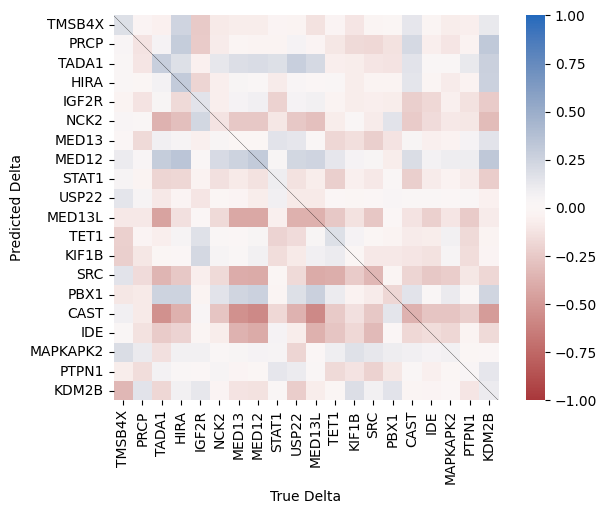

In [28]:
# Load
imputed_means = pd.read_csv('../plots/vcc/imputed_means.csv', index_col=0)
raw_means = pd.read_csv('../plots/vcc/raw_means.csv', index_col=0).iloc[:imputed_means.shape[0]]

# Transform
# imputed_means[:], = preprocessing_nopca.inverse_transform([imputed_means.to_numpy()])
# raw_means[:], = preprocessing_nopca.inverse_transform([raw_means.to_numpy()])

# Lose information from PCA
# raw_means[:], = preprocessing.inverse_transform(preprocessing.transform([raw_means.to_numpy()]))  # Invalid if log
# raw_means[:], = preprocessing_nopca.transform(preprocessing.inverse_transform(preprocessing.transform(preprocessing_nopca.inverse_transform([raw_means.to_numpy()]))))

# Get differences
imputed_mean_diffs = imputed_means.iloc[2:] - imputed_means.loc['_ctl_post']
# imputed_mean_diffs = imputed_means.iloc[2:] - imputed_means.loc['_ctl_pre']
# imputed_mean_diffs = imputed_means.iloc[2:] - raw_means.loc['_ctl_post']
raw_mean_diffs = raw_means.iloc[2:] - raw_means.loc['_ctl_post']

# Get 1k highly variant genes
assert preprocessing.filter_mask[0] is None
# high_var_idx = preprocessing.standardize_std[0][0].argsort()[::-1][:1000]
high_var_idx = np.array(np.argsort(np.std(adata.X[:1000].log1p().todense(), axis=0))).flatten()[::-1][:200]
high_var_genes = adata.var.index[high_var_idx]

# Compute correlations
cross_correlation = np.corrcoef(imputed_mean_diffs, raw_mean_diffs)[:imputed_mean_diffs.shape[0], -raw_mean_diffs.shape[0]:]
# cross_correlation = np.corrcoef(imputed_mean_diffs[high_var_genes], raw_mean_diffs[high_var_genes])[:imputed_mean_diffs.shape[0], -raw_mean_diffs.shape[0]:]
cross_correlation = pd.DataFrame(cross_correlation, index=imputed_mean_diffs.index, columns=raw_mean_diffs.index)

# Dendogram sorting
# dist = scipy.spatial.distance.pdist(cross_correlation.T)
# linkage = scipy.cluster.hierarchy.linkage(dist, method='ward')
# ordered_linkage = scipy.cluster.hierarchy.optimal_leaf_ordering(linkage, dist)
# ordered_leaves = scipy.cluster.hierarchy.leaves_list(ordered_linkage)
# cross_correlation = cross_correlation.iloc[ordered_leaves, ordered_leaves]

# Format correlation matrix
cross_correlation_scaled_col = (cross_correlation - np.min(cross_correlation, axis=0)) / (np.max(cross_correlation, axis=0) - np.min(cross_correlation, axis=0))
cross_correlation_scaled_row = (cross_correlation - np.min(cross_correlation, axis=1)) / (np.max(cross_correlation, axis=1) - np.min(cross_correlation, axis=1))
cross_correlation_rank = cross_correlation.shape[0] - np.argsort(np.argsort(cross_correlation, axis=0), axis=0)
cross_correlation_rank = pd.DataFrame(cross_correlation_rank, index=imputed_mean_diffs.index, columns=raw_mean_diffs.index)

# Diagonal summary
pert_summary = pd.DataFrame({
    'Gene': cross_correlation.index,
    'Rank': np.diag(cross_correlation_rank),
    'Correlation': np.diag(cross_correlation),
    'Observed Expression': raw_means.loc['_ctl_post', raw_mean_diffs.index],
    'Observed Knockdown': np.diag(raw_mean_diffs[raw_mean_diffs.index]),
    'Observed Knocked Expression': raw_means.loc['_ctl_post', raw_mean_diffs.index] + np.diag(raw_mean_diffs[raw_mean_diffs.index]),
    'Observed Knockdown Rank': 1 + np.diag(np.argsort(np.argsort(raw_mean_diffs[raw_mean_diffs.index], axis=0), axis=0)),
    'Imputed Expression': imputed_means.loc['_ctl_post', imputed_mean_diffs.index],
    'Imputed Knockdown': np.diag(imputed_mean_diffs[imputed_mean_diffs.index]),
    'Imputed Knocked Expression': imputed_means.loc['_ctl_post', imputed_mean_diffs.index] + np.diag(imputed_mean_diffs[imputed_mean_diffs.index]),
    'Imputed Knockdown Rank': 1 + np.diag(np.argsort(np.argsort(imputed_mean_diffs[imputed_mean_diffs.index], axis=0), axis=0))})
pert_summary['Ratio'] = pert_summary['Imputed Knockdown'] / pert_summary['Observed Knockdown']

# Plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.heatmap(cross_correlation, cmap='vlag_r', vmin=-1, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_scaled_col, cmap='Blues', vmin=0, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_scaled_row, cmap='Blues', vmin=0, vmax=1, ax=ax)
# sns.heatmap(cross_correlation_rank, cmap='Blues_r', vmin=1, vmax=cross_correlation.shape[0], ax=ax)
ax.plot([0, cross_correlation.shape[0]], [0, cross_correlation.shape[0]], lw=.2, color='black')
ax.set(xlabel='True Delta', ylabel='Predicted Delta')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_aspect('equal')


In [29]:
pert_summary


,Gene,Rank,Correlation,Observed Expression,Observed Knockdown,Observed Knocked Expression,Observed Knockdown Rank,Imputed Expression,Imputed Knockdown,Imputed Knocked Expression,Imputed Knockdown Rank,Ratio
TMSB4X,TMSB4X,2,0.174869,135.356030,-128.957514,6.398516,1,23.761063,-23.754186,0.006877,1,0.184202
PRCP,PRCP,16,-0.120982,6.184002,-5.831656,0.352347,1,0.958156,-0.958287,-0.000131,1,0.164325
TADA1,TADA1,2,0.276568,1.153998,-1.100962,0.053036,1,0.191706,-0.191769,-0.000063,1,0.174183
HIRA,HIRA,2,0.303835,9.302001,-1.225353,8.076648,1,1.546351,-1.545570,0.000781,1,1.261326
IGF2R,IGF2R,4,0.155170,3.721999,-3.375907,0.346092,1,0.554573,-0.554491,0.000082,1,0.164249
NCK2,NCK2,16,-0.123065,2.059996,-1.954500,0.105497,1,0.332475,-0.332497,-0.000022,1,0.170119
MED13,MED13,9,-0.013263,6.088000,-5.761844,0.326157,1,1.030891,-1.030907,-0.000016,1,0.178920
MED12,MED12,1,0.303800,4.383997,-4.195639,0.188358,1,0.620615,-0.620145,0.000470,1,0.147807
STAT1,STAT1,4,0.099195,3.175997,-2.997096,0.178901,1,0.570323,-0.570024,0.000299,1,0.190192
USP22,USP22,12,-0.090180,20.932000,-20.000250,0.931750,1,3.582980,-3.582943,0.000037,1,0.179145


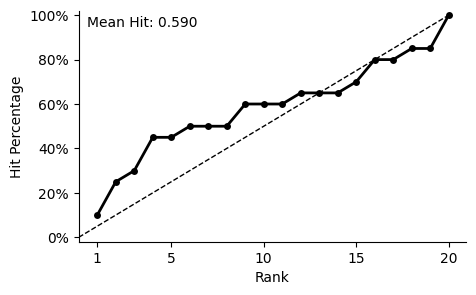

In [30]:
# Get hit df
df = pd.DataFrame({'Rank': 1+np.arange(pert_summary.shape[0])})
df['Hits'] = df['Rank'].apply(lambda r: (pert_summary['Rank'] <= r).sum())
df['Hit Percentage'] = df['Hits'] / pert_summary.shape[0]
auc = df['Hit Percentage'].mean()  # * (df.shape[0]/(df.shape[0]+1))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.lineplot(df, x='Rank', y='Hit Percentage', lw=2, marker='.', markersize=10, markeredgecolor='none', color='black', ax=ax)
sns.despine(ax=ax)
ax.set_xlim(left=0)
ax.set_ylim(-.02, 1.02)
ax.set_xticks([1]+np.arange(5, pert_summary.shape[0]+5, 5).tolist())
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.))
ax.text(.02, .98, f'Mean Hit: {auc:.3f}', ha='left', va='top', fontsize='medium', transform=ax.transAxes)
ax.plot([0, pert_summary.shape[0]], [0, 1], ls='--', lw=1, color='black');


/tmp/ipykernel_3288/2494286718.py:14: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(-max_ylim, max_ylim)


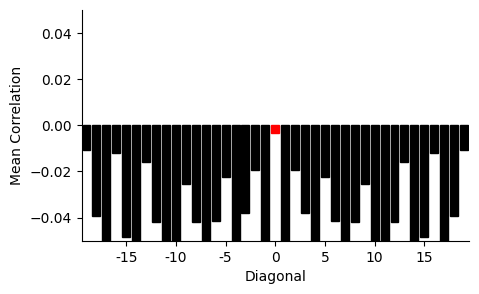

In [32]:
# Get hit df
df = pd.DataFrame({'Diagonal': np.arange(-pert_summary.shape[0]+1, pert_summary.shape[0])})
diag_corr = [np.diag(np.roll(cross_correlation, i, axis=0)).mean() for i in range(cross_correlation.shape[0])]
df['Mean Correlation'] = diag_corr[:0:-1] + diag_corr

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
bar = sns.barplot(df, x='Diagonal', y='Mean Correlation', color='black', edgecolor='black', ax=ax)
# Highlight
ax.patches[len(diag_corr)-1].set(color='red', edgecolor='red')
# Styling
sns.despine(ax=ax)
max_ylim = max(*ax.get_ylim())
ax.set_ylim(-max_ylim, max_ylim)
xticks = np.arange(0, len(diag_corr), 5)
xticks = np.concat([-xticks[:0:-1], xticks])
ax.set(xticks=xticks+df['Diagonal'].max(), xticklabels=xticks);


/tmp/ipykernel_3288/2340559097.py:15: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  bar = sns.barplot(df.loc[df['Type'].str.endswith('Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightblue'], edgecolor='none', width=.8, ax=ax)
/tmp/ipykernel_3288/2340559097.py:16: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  bar = sns.barplot(df.loc[df['Type'].str.endswith('Knocked Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightcoral'], edgecolor='none', width=.4, ax=ax)


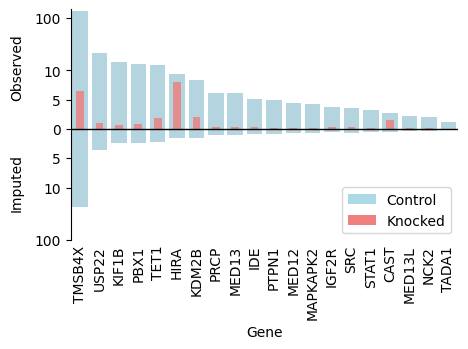

In [33]:
# Pivot
df = pert_summary.melt(
    id_vars='Gene',
    value_vars=[
        'Observed Expression', 'Imputed Expression',
        # 'Observed Knockdown', 'Imputed Knockdown',
        'Observed Knocked Expression', 'Imputed Knocked Expression'],
    var_name='Type', value_name='Value').sort_values('Value', ascending=False)
df.loc[df['Type'].str.startswith('Imputed'), 'Value'] *= -1

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# bar = sns.barplot(df.loc[df['Type'].str.endswith('Observed')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightblue', 'lightblue'], edgecolor='none', width=.8, ax=ax)
# bar = sns.barplot(df.loc[df['Type'].str.startswith('Imputed')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightcoral', 'lightcoral'], edgecolor='none', width=.4, ax=ax)
bar = sns.barplot(df.loc[df['Type'].str.endswith('Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightblue'], edgecolor='none', width=.8, ax=ax)
bar = sns.barplot(df.loc[df['Type'].str.endswith('Knocked Expression')], x='Gene', y='Value', hue='Type', dodge=False, palette=['lightcoral'], edgecolor='none', width=.4, ax=ax)
# bar.get_legend().set_title('')
ax.set_yscale('symlog', linthresh=10)
ax.axhline(y=0, lw=1., color='black')
yticks = [-100, -10, -5, 0, 5, 10, 100]
ax.set(yticks=yticks, yticklabels=np.abs(yticks))
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# Styling
sns.despine(bottom=True, ax=ax)
ax.tick_params(axis='x', which='major', length=0)
ax.set_ylabel(None)
# ax.text(-.12, .75, 'Expression', ha='right', va='center', rotation=90, transform=ax.transAxes)
# ax.text(-.12, .25, 'Knockdown', ha='right', va='center', rotation=90, transform=ax.transAxes)
ax.text(-.12, .75, 'Observed', ha='right', va='center', rotation=90, transform=ax.transAxes)
ax.text(-.12, .25, 'Imputed', ha='right', va='center', rotation=90, transform=ax.transAxes)
# Legend
patches = [
    mpl.patches.Patch(facecolor='lightblue', edgecolor='none'),
    mpl.patches.Patch(facecolor='lightcoral', edgecolor='none')]
# labels = ['Observed', 'Imputed']
labels = ['Control', 'Knocked']
ax.legend(patches, labels, loc='lower right');
